In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, precision_recall_curve, auc,make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
#import warnings
#warnings.filterwarnings('ignore')
import os

In [2]:
data_path = os.path.dirname(os.getcwd())

In [3]:
data = pd.read_csv(data_path+'/Data/Class imbalance/churn.csv')
#data.Class.replace(["'0'","'1'"],[0,1],inplace=True)
data.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
0,16,128,415,2845,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,2301,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,1616,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,2510,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,155,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [4]:
data.nunique()

state                              51
account_length                    218
area_code                           3
phone_number                     5000
international_plan                  2
voice_mail_plan                     2
number_vmail_messages              48
total_day_minutes                1961
total_day_calls                   123
total_day_charge                 1961
total_eve_minutes                1879
total_eve_calls                   126
total_eve_charge                 1659
total_night_minutes              1853
total_night_calls                 131
total_night_charge               1028
total_intl_minutes                170
total_intl_calls                   21
total_intl_charge                 170
number_customer_service_calls      10
class                               2
dtype: int64

In [5]:
data['class'].value_counts() #Label counts

0    4293
1     707
Name: class, dtype: int64

In [6]:
data.isna().values.any() #Check if any NaN value

False

In [7]:
df_train, df_test = train_test_split(data, test_size=0.25, random_state=0)
train_x = df_train.drop('class',axis=1)
test_x = df_test.drop('class',axis=1)
train_y = df_train['class']
test_y = df_test['class']

In [8]:
def kprecision(y_true, y_predicted, k):
    idx = np.argsort(y_predicted)
    tp = np.sum(y_true[idx[-k:]])
    return tp/k

In [9]:
def aupr_scorer(test_y,y_pred):
    precision, recall, thresholds = precision_recall_curve(test_y,y_pred)
    aupr = auc(recall,precision)
    return aupr

In [10]:
aupr_cvscorer = make_scorer(aupr_scorer)

## Baseline 

In [9]:
parameters = {'C':[10**k for k in range(-3,4)],'penalty':['l2','l1']}
lr = LogisticRegression(solver='liblinear')
baseline = GridSearchCV(lr, parameters, cv=5, return_train_score=True, scoring='roc_auc').fit(train_x, train_y)
clf = baseline.best_estimator_.fit(train_x,train_y)
y_pred = clf.predict_proba(test_x)[:,1]

Baseline NLL loss: 0.30778341217610433, precision@25: 0.56


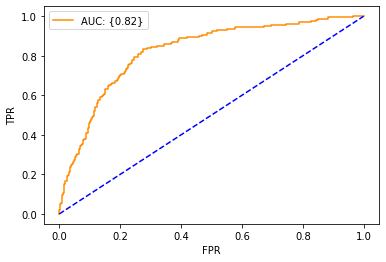

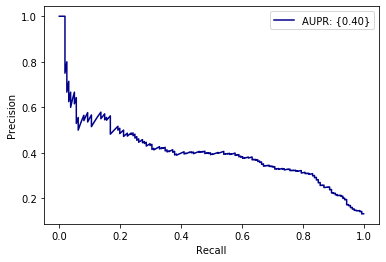

In [16]:
print('Baseline NLL loss: {}, precision@25: {}'.format(log_loss(test_y.values,y_pred), 
                                                                kprecision(test_y.values,y_pred,25)))
fpr, tpr, thresholds = roc_curve(test_y.values,y_pred)
plt.plot(fpr, tpr, color='darkorange',label = 'AUC: {%.2f}'%auc(fpr,tpr))
plt.plot([0,1],[0,1],color='blue',linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

precision, recall, thresholds = precision_recall_curve(test_y.values,y_pred)
aupr = auc(recall,precision)
plt.plot(recall, precision, color='darkblue', label='AUPR: {%.2f}'%aupr)
#plt.plot([0,1],[0,1],color='blue',linestyle='--')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

## Undersampling 


100%|██████████| 6/6 [21:00<00:00, 210.03s/it]


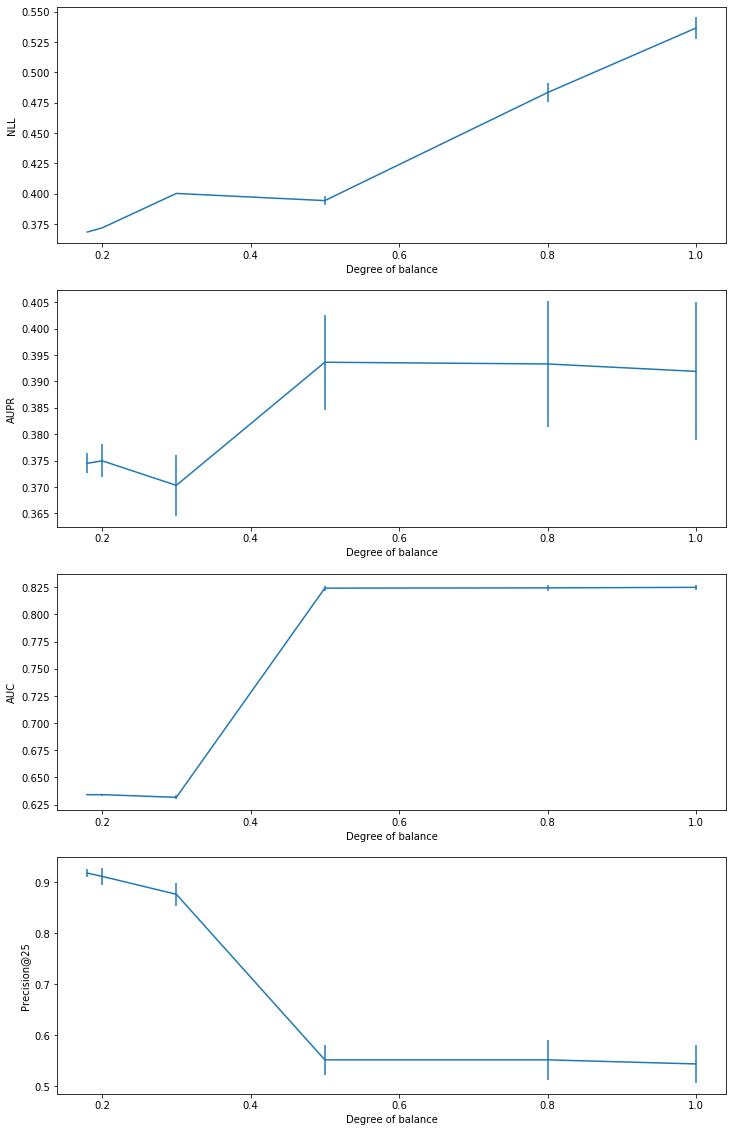

In [12]:
fractions = [1,0.8,0.5,0.3,0.2,0.18]
parameters = {'C':[10**k for k in range(-3,4)],'penalty':['l2','l1']}
n_bootstrap = 25
plt.figure(figsize=(12,20))
plt.subplot(211)
ax1 = plt.subplot(4, 1, 1)
#ax1.set_xscale('log')
ax1.set_xlabel('Degree of balance')
ax1.set_ylabel('NLL')
ax2 = plt.subplot(4, 1, 2)
#ax3.set_xscale('log')
ax2.set_xlabel('Degree of balance')
ax2.set_ylabel('AUPR')
ax3 = plt.subplot(4, 1, 3)
#ax2.set_xscale('log')
ax3.set_xlabel('Degree of balance')
ax3.set_ylabel('AUC')
ax4 = plt.subplot(4, 1, 4)
#ax3.set_xscale('log')
ax4.set_xlabel('Degree of balance')
ax4.set_ylabel('Precision@{}'.format(25))

mean_auc_us = []
std_auc_us = []
mean_aupr_us = []
std_aupr_us = []
std_nll_us = []
mean_nll_us = []
std_prec_us = []
mean_prec_us = []

for f in tqdm(fractions):
    aucs=[]
    precisions=[]
    log_losses=[]
    auprs = []
    for r in range(n_bootstrap):
        rus = RandomUnderSampler(sampling_strategy=f,random_state=r)
        train_x_resampled, train_y_resampled = rus.fit_resample(train_x, train_y)
        #print(train_y_resampled.value_counts())
        lr = LogisticRegression(solver='liblinear',max_iter=5000)
        cv_estimator = GridSearchCV(lr, parameters, cv=5, return_train_score=True, scoring=aupr_cvscorer).fit(train_x_resampled, train_y_resampled)
        clf = cv_estimator.best_estimator_.fit(train_x_resampled,train_y_resampled)
        y_pred = clf.predict_proba(test_x)[:,1]
        auprs.append(aupr_scorer(test_y.values,y_pred))
        aucs.append(roc_auc_score(test_y.values,y_pred))
        log_losses.append(log_loss(test_y.values,y_pred))
        precisions.append(kprecision(test_y.values,y_pred,25))
    mean_aupr_us.append(np.mean(auprs))
    std_aupr_us.append(np.std(auprs))
    mean_auc_us.append(np.mean(aucs))
    std_auc_us.append(np.std(aucs))
    mean_nll_us.append(np.mean(log_losses))
    std_nll_us.append(np.std(log_losses))
    mean_prec_us.append(np.mean(precisions))
    std_prec_us.append(np.std(precisions))
    
ax1.errorbar(fractions, mean_nll_us, std_nll_us)
ax2.errorbar(fractions, mean_aupr_us, std_aupr_us)
ax3.errorbar(fractions, mean_auc_us, std_auc_us)
ax4.errorbar(fractions, mean_prec_us, std_prec_us)


plt.show()



## Undersampling with matching test distribution


100%|██████████| 6/6 [07:38<00:00, 76.48s/it]


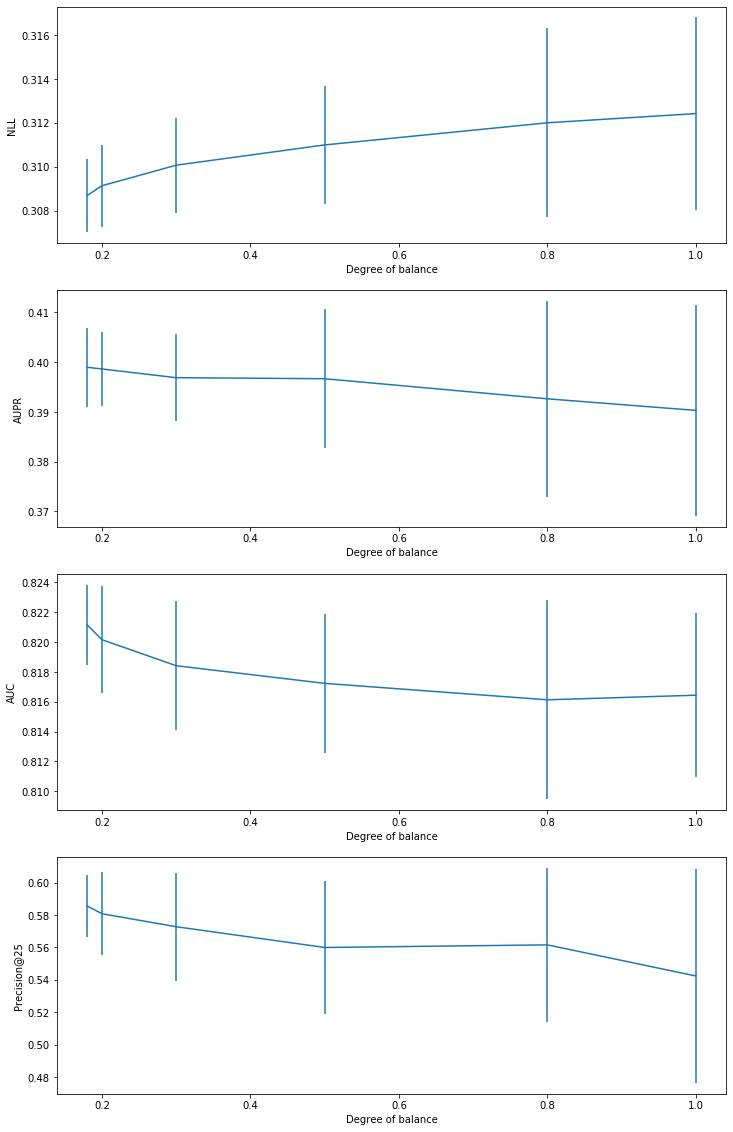

In [13]:
fractions = [1,0.8,0.5,0.3,0.2,0.18]
parameters = {'C':[10**k for k in range(-3,4)],'penalty':['l2','l1']}
n_bootstrap = 25
plt.figure(figsize=(12,20))
plt.subplot(211)
ax1 = plt.subplot(4, 1, 1)
#ax1.set_xscale('log')
ax1.set_xlabel('Degree of balance')
ax1.set_ylabel('NLL')
ax2 = plt.subplot(4, 1, 2)
#ax3.set_xscale('log')
ax2.set_xlabel('Degree of balance')
ax2.set_ylabel('AUPR')
ax3 = plt.subplot(4, 1, 3)
#ax2.set_xscale('log')
ax3.set_xlabel('Degree of balance')
ax3.set_ylabel('AUC')
ax4 = plt.subplot(4, 1, 4)
#ax3.set_xscale('log')
ax4.set_xlabel('Degree of balance')
ax4.set_ylabel('Precision@{}'.format(25))

mean_auc_us = []
std_auc_us = []
mean_aupr_us = []
std_aupr_us = []
std_nll_us = []
mean_nll_us = []
std_prec_us = []
mean_prec_us = []

n_0 = train_y.size-train_y.sum()
n_1 = train_y.sum()

for f in tqdm(fractions):
    aucs=[]
    precisions=[]
    log_losses=[]
    auprs = []
    for r in range(n_bootstrap):
        rus = RandomUnderSampler(sampling_strategy=f,random_state=r)
        train_x_resampled, train_y_resampled = rus.fit_resample(train_x, train_y)
        #print(train_y_resampled.value_counts())
        cw = {0:f*n_0/(1+f),1:1*n_1/(1+f)}
        lr = LogisticRegression(solver='liblinear',max_iter=5000, class_weight=cw)
        cv_estimator = GridSearchCV(lr, parameters, cv=3, return_train_score=True, scoring=aupr_cvscorer).fit(train_x_resampled, train_y_resampled)
        clf = cv_estimator.best_estimator_.fit(train_x_resampled,train_y_resampled)
        y_pred = clf.predict_proba(test_x)[:,1]
        auprs.append(aupr_scorer(test_y.values,y_pred))
        aucs.append(roc_auc_score(test_y.values,y_pred))
        log_losses.append(log_loss(test_y.values,y_pred))
        precisions.append(kprecision(test_y.values,y_pred,25))
    mean_aupr_us.append(np.mean(auprs))
    std_aupr_us.append(np.std(auprs))
    mean_auc_us.append(np.mean(aucs))
    std_auc_us.append(np.std(aucs))
    mean_nll_us.append(np.mean(log_losses))
    std_nll_us.append(np.std(log_losses))
    mean_prec_us.append(np.mean(precisions))
    std_prec_us.append(np.std(precisions))
    
ax1.errorbar(fractions, mean_nll_us, std_nll_us)
ax2.errorbar(fractions, mean_aupr_us, std_aupr_us)
ax3.errorbar(fractions, mean_auc_us, std_auc_us)
ax4.errorbar(fractions, mean_prec_us, std_prec_us)


plt.show()



## Learning curve analysis

100%|██████████| 10/10 [18:26<00:00, 80.10s/it]


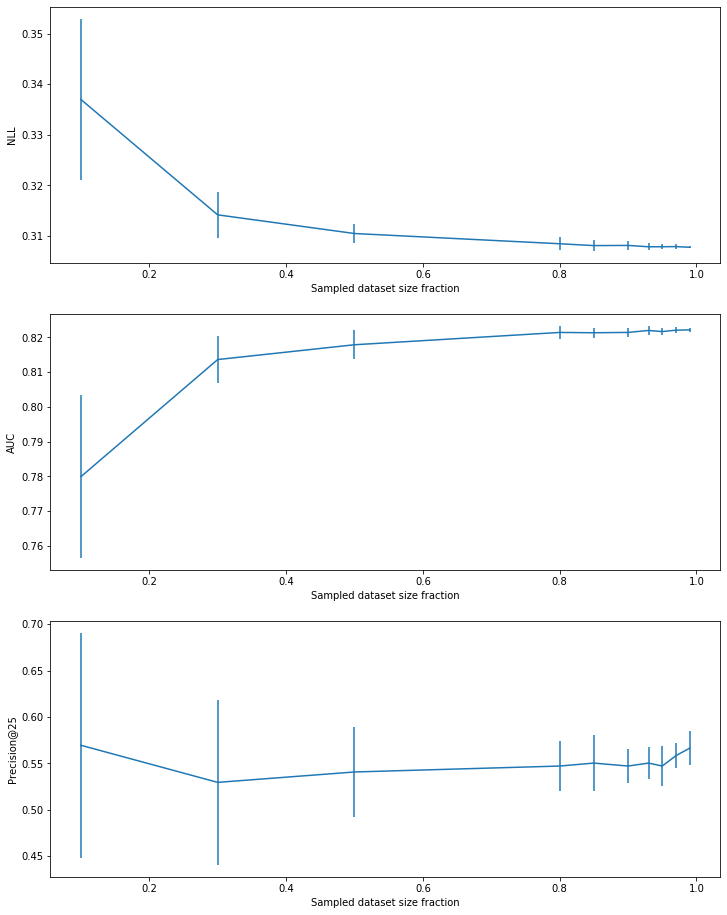

In [19]:
fractions = [0.99,0.97,0.95,0.93,0.9,0.85,0.8,0.5,0.3,0.1]
parameters = {'C':[10**k for k in range(-4,3)],'penalty':['l2','l1']}
n_bootstrap = 25
plt.figure(figsize=(12,16))
plt.subplot(211)
ax1 = plt.subplot(3, 1, 1)
#ax1.set_xscale('log')
ax1.set_xlabel('Sampled dataset size fraction')
ax1.set_ylabel('NLL')
ax2 = plt.subplot(3, 1, 2)
#ax2.set_xscale('log')
ax2.set_xlabel('Sampled dataset size fraction')
ax2.set_ylabel('AUC')
ax3 = plt.subplot(3, 1, 3)
#ax3.set_xscale('log')
ax3.set_xlabel('Sampled dataset size fraction')
ax3.set_ylabel('Precision@{}'.format(25))
mean_auc_us = []
std_auc_us = []
std_nll_us = []
mean_nll_us = []
std_prec_us = []
mean_prec_us = []

for f in tqdm(fractions):
    auc=[]
    precisions=[]
    log_losses=[]
    for r in range(n_bootstrap):
        train_x_resampled, _, train_y_resampled, _ = train_test_split(train_x, train_y, train_size=f)
        #print(train_y_resampled.value_counts())
        lr = LogisticRegression(solver='liblinear',max_iter=1000)
        cv_estimator = GridSearchCV(lr, parameters, cv=3, return_train_score=True, scoring='roc_auc').fit(train_x_resampled, train_y_resampled)
        clf = cv_estimator.best_estimator_.fit(train_x_resampled,train_y_resampled)
        y_pred = clf.predict_proba(test_x)[:,1]
        auc.append(roc_auc_score(test_y.values,y_pred))
        log_losses.append(log_loss(test_y.values,y_pred))
        precisions.append(precision(test_y.values,y_pred,25))
    mean_auc_us.append(np.mean(auc))
    std_auc_us.append(np.std(auc))
    mean_nll_us.append(np.mean(log_losses))
    std_nll_us.append(np.std(log_losses))
    mean_prec_us.append(np.mean(precisions))
    std_prec_us.append(np.std(precisions))
    
ax1.errorbar(fractions, mean_nll_us, std_nll_us)
ax2.errorbar(fractions, mean_auc_us, std_auc_us)
ax3.errorbar(fractions, mean_prec_us, std_prec_us)

plt.show()



## Oversampling 


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:27<11:04, 27.69s/it]

  8%|▊         | 2/25 [01:02<11:26, 29.87s/it]

 12%|█▏        | 3/25 [01:29<10:34, 28.86s/it]

 16%|█▌        | 4/25 [02:06<11:02, 31.53s/it]

 20%|██        | 5/25 [02:34<10:04, 30.21s/it]

 24%|██▍       | 6/25 [02:57<08:56, 28.26s/it]

 28%|██▊       | 7/25 [03:26<08:31, 28.43s/it]

 32%|███▏      | 8/25 [03:50<07:39, 27.05s/it]

 36%|███▌      | 9/25 [04:16<07:08, 26.80s/it]

 40%|████      | 10/25 [04:41<06:31, 26.12s/it]

 44%|████▍     | 11/25 [05:14<06:38, 28.44s/it]

 48%|████▊     | 12/25 [05:50<06:38, 30.67s/it]

 52%|█████▏    | 13/25 [06:20<06:05, 30.48s/it]

 56%|█████▌    | 14/25 [06:47<05:22, 29.29s/it]

 60%|██████    | 15/25 [07:15<04:50, 29.05s/it]

 64%|██████▍   | 16/25 [07:42<04:15, 28.38s/it]

 68%|██████▊   | 17/25 [08:21<04:11, 31.43s/it]

 72%|███████▏  | 18/25 [08:47<03:29, 29.95s/it]

 76%|███████▌  | 19/25 [09:39<03:38, 36.46s/it]

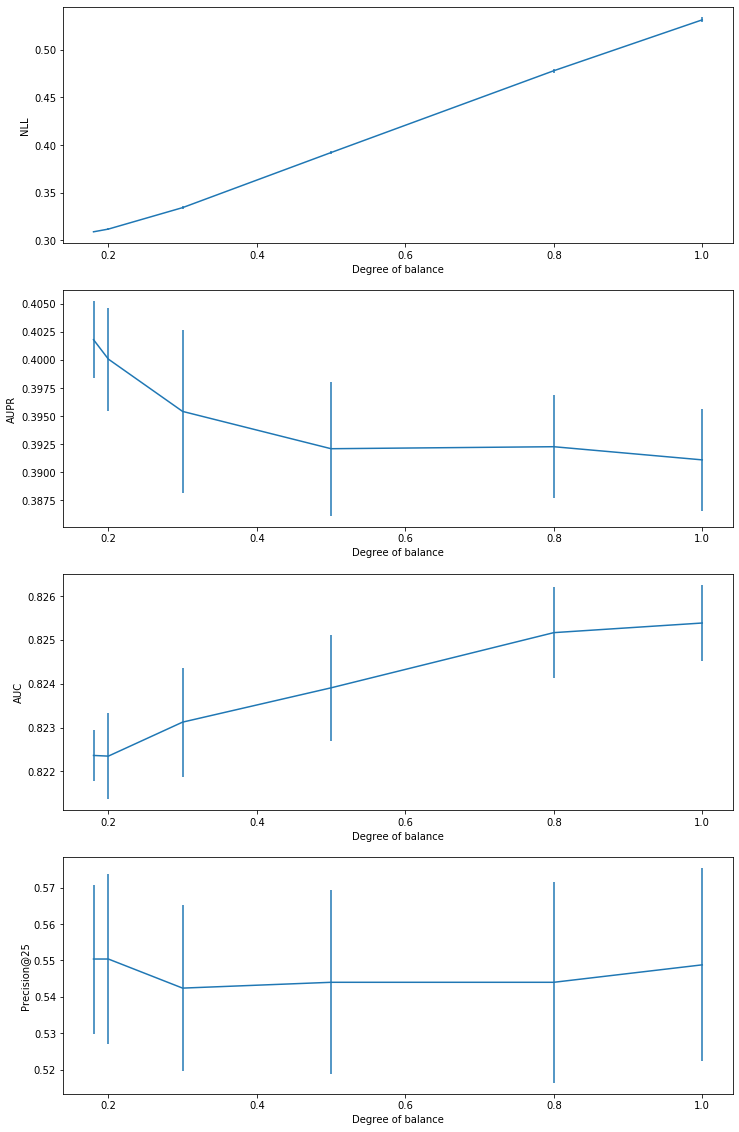

In [14]:
fractions = [1,0.8,0.5,0.3,0.2,0.18]
parameters = {'C':[10**k for k in range(-3,4)],'penalty':['l2','l1']}
n_bootstrap = 25
plt.figure(figsize=(12,20))
plt.subplot(211)
ax1 = plt.subplot(4, 1, 1)
#ax1.set_xscale('log')
ax1.set_xlabel('Degree of balance')
ax1.set_ylabel('NLL')
ax2 = plt.subplot(4, 1, 2)
#ax3.set_xscale('log')
ax2.set_xlabel('Degree of balance')
ax2.set_ylabel('AUPR')
ax3 = plt.subplot(4, 1, 3)
#ax2.set_xscale('log')
ax3.set_xlabel('Degree of balance')
ax3.set_ylabel('AUC')
ax4 = plt.subplot(4, 1, 4)
#ax3.set_xscale('log')
ax4.set_xlabel('Degree of balance')
ax4.set_ylabel('Precision@{}'.format(25))

mean_auc_us = []
std_auc_us = []
mean_aupr_us = []
std_aupr_us = []
std_nll_us = []
mean_nll_us = []
std_prec_us = []
mean_prec_us = []

for f in tqdm(fractions):
    aucs=[]
    precisions=[]
    log_losses=[]
    auprs = []
    for r in tqdm(range(n_bootstrap)):
        ros = RandomOverSampler(sampling_strategy=f,random_state=r)
        train_x_resampled, train_y_resampled = ros.fit_resample(train_x, train_y)
        #print(train_y_resampled.value_counts())
        lr = LogisticRegression(solver='liblinear',max_iter=1000)
        cv_estimator = GridSearchCV(lr, parameters, cv=3, return_train_score=True, scoring='roc_auc').fit(train_x_resampled, train_y_resampled)
        clf = cv_estimator.best_estimator_.fit(train_x_resampled,train_y_resampled)
        y_pred = clf.predict_proba(test_x)[:,1]
        auprs.append(aupr_scorer(test_y.values,y_pred))
        aucs.append(roc_auc_score(test_y.values,y_pred))
        log_losses.append(log_loss(test_y.values,y_pred))
        precisions.append(kprecision(test_y.values,y_pred,25))
    mean_aupr_us.append(np.mean(auprs))
    std_aupr_us.append(np.std(auprs))
    mean_auc_us.append(np.mean(aucs))
    std_auc_us.append(np.std(aucs))
    mean_nll_us.append(np.mean(log_losses))
    std_nll_us.append(np.std(log_losses))
    mean_prec_us.append(np.mean(precisions))
    std_prec_us.append(np.std(precisions))
    
ax1.errorbar(fractions, mean_nll_us, std_nll_us)
ax2.errorbar(fractions, mean_aupr_us, std_aupr_us)
ax3.errorbar(fractions, mean_auc_us, std_auc_us)
ax4.errorbar(fractions, mean_prec_us, std_prec_us)


plt.show()






  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:29<11:49, 29.56s/it]

  8%|▊         | 2/25 [00:57<11:06, 28.97s/it]

 12%|█▏        | 3/25 [01:22<10:10, 27.77s/it]

 16%|█▌        | 4/25 [01:48<09:32, 27.25s/it]

 20%|██        | 5/25 [02:12<08:45, 26.27s/it]

 24%|██▍       | 6/25 [02:37<08:12, 25.94s/it]

 28%|██▊       | 7/25 [03:03<07:47, 26.00s/it]

 32%|███▏      | 8/25 [03:26<07:05, 25.05s/it]

 36%|███▌      | 9/25 [03:50<06:35, 24.75s/it]

 40%|████      | 10/25 [04:11<05:56, 23.77s/it]

 44%|████▍     | 11/25 [04:42<06:00, 25.73s/it]

 48%|████▊     | 12/25 [05:04<05:22, 24.79s/it]

 52%|█████▏    | 13/25 [05:25<04:44, 23.73s/it]

 56%|█████▌    | 14/25 [05:49<04:21, 23.78s/it]

 60%|██████    | 15/25 [06:15<04:03, 24.33s/it]

 64%|██████▍   | 16/25 [06:38<03:34, 23.85s/it]

 68%|██████▊   | 17/25 [07:08<03:26, 25.78s/it]

 72%|███████▏  | 18/25 [07:33<02:58, 25.52s/it]

 76%|███████▌  | 19/25 [08:04<02:42, 27.05s/it]

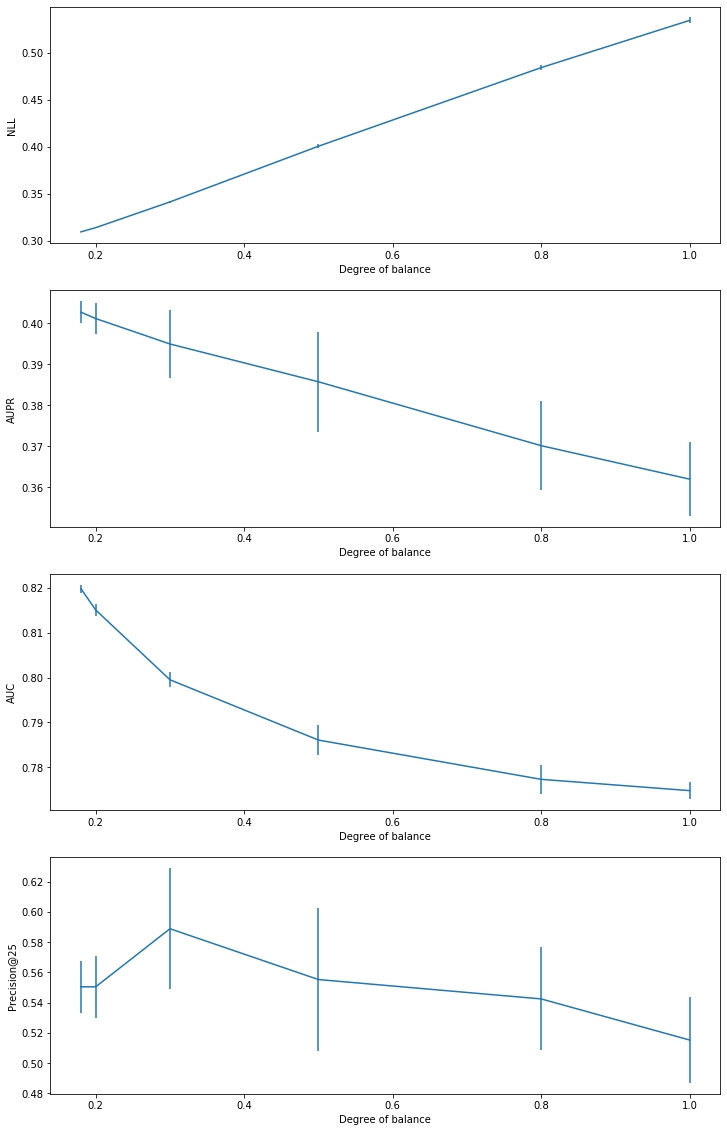

In [15]:
fractions = [1,0.8,0.5,0.3,0.2,0.18]
parameters = {'C':[10**k for k in range(-3,4)],'penalty':['l2','l1']}
n_bootstrap = 25
plt.figure(figsize=(12,20))
plt.subplot(211)
ax1 = plt.subplot(4, 1, 1)
#ax1.set_xscale('log')
ax1.set_xlabel('Degree of balance')
ax1.set_ylabel('NLL')
ax2 = plt.subplot(4, 1, 2)
#ax3.set_xscale('log')
ax2.set_xlabel('Degree of balance')
ax2.set_ylabel('AUPR')
ax3 = plt.subplot(4, 1, 3)
#ax2.set_xscale('log')
ax3.set_xlabel('Degree of balance')
ax3.set_ylabel('AUC')
ax4 = plt.subplot(4, 1, 4)
#ax3.set_xscale('log')
ax4.set_xlabel('Degree of balance')
ax4.set_ylabel('Precision@{}'.format(25))

mean_auc_us = []
std_auc_us = []
mean_aupr_us = []
std_aupr_us = []
std_nll_us = []
mean_nll_us = []
std_prec_us = []
mean_prec_us = []

for f in tqdm(fractions):
    aucs=[]
    precisions=[]
    log_losses=[]
    auprs = []
    for r in tqdm(range(n_bootstrap)):
        os = SMOTE(sampling_strategy=f,random_state=r)
        train_x_resampled, train_y_resampled = os.fit_resample(train_x, train_y)
        #print(train_y_resampled.value_counts())
        lr = LogisticRegression(solver='liblinear',max_iter=1000)
        cv_estimator = GridSearchCV(lr, parameters, cv=3, return_train_score=True, scoring='roc_auc').fit(train_x_resampled, train_y_resampled)
        clf = cv_estimator.best_estimator_.fit(train_x_resampled,train_y_resampled)
        y_pred = clf.predict_proba(test_x)[:,1]
        auprs.append(aupr_scorer(test_y.values,y_pred))
        aucs.append(roc_auc_score(test_y.values,y_pred))
        log_losses.append(log_loss(test_y.values,y_pred))
        precisions.append(kprecision(test_y.values,y_pred,25))
    mean_aupr_us.append(np.mean(auprs))
    std_aupr_us.append(np.std(auprs))
    mean_auc_us.append(np.mean(aucs))
    std_auc_us.append(np.std(aucs))
    mean_nll_us.append(np.mean(log_losses))
    std_nll_us.append(np.std(log_losses))
    mean_prec_us.append(np.mean(precisions))
    std_prec_us.append(np.std(precisions))
    
ax1.errorbar(fractions, mean_nll_us, std_nll_us)
ax2.errorbar(fractions, mean_aupr_us, std_aupr_us)
ax3.errorbar(fractions, mean_auc_us, std_auc_us)
ax4.errorbar(fractions, mean_prec_us, std_prec_us)


plt.show()

